In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

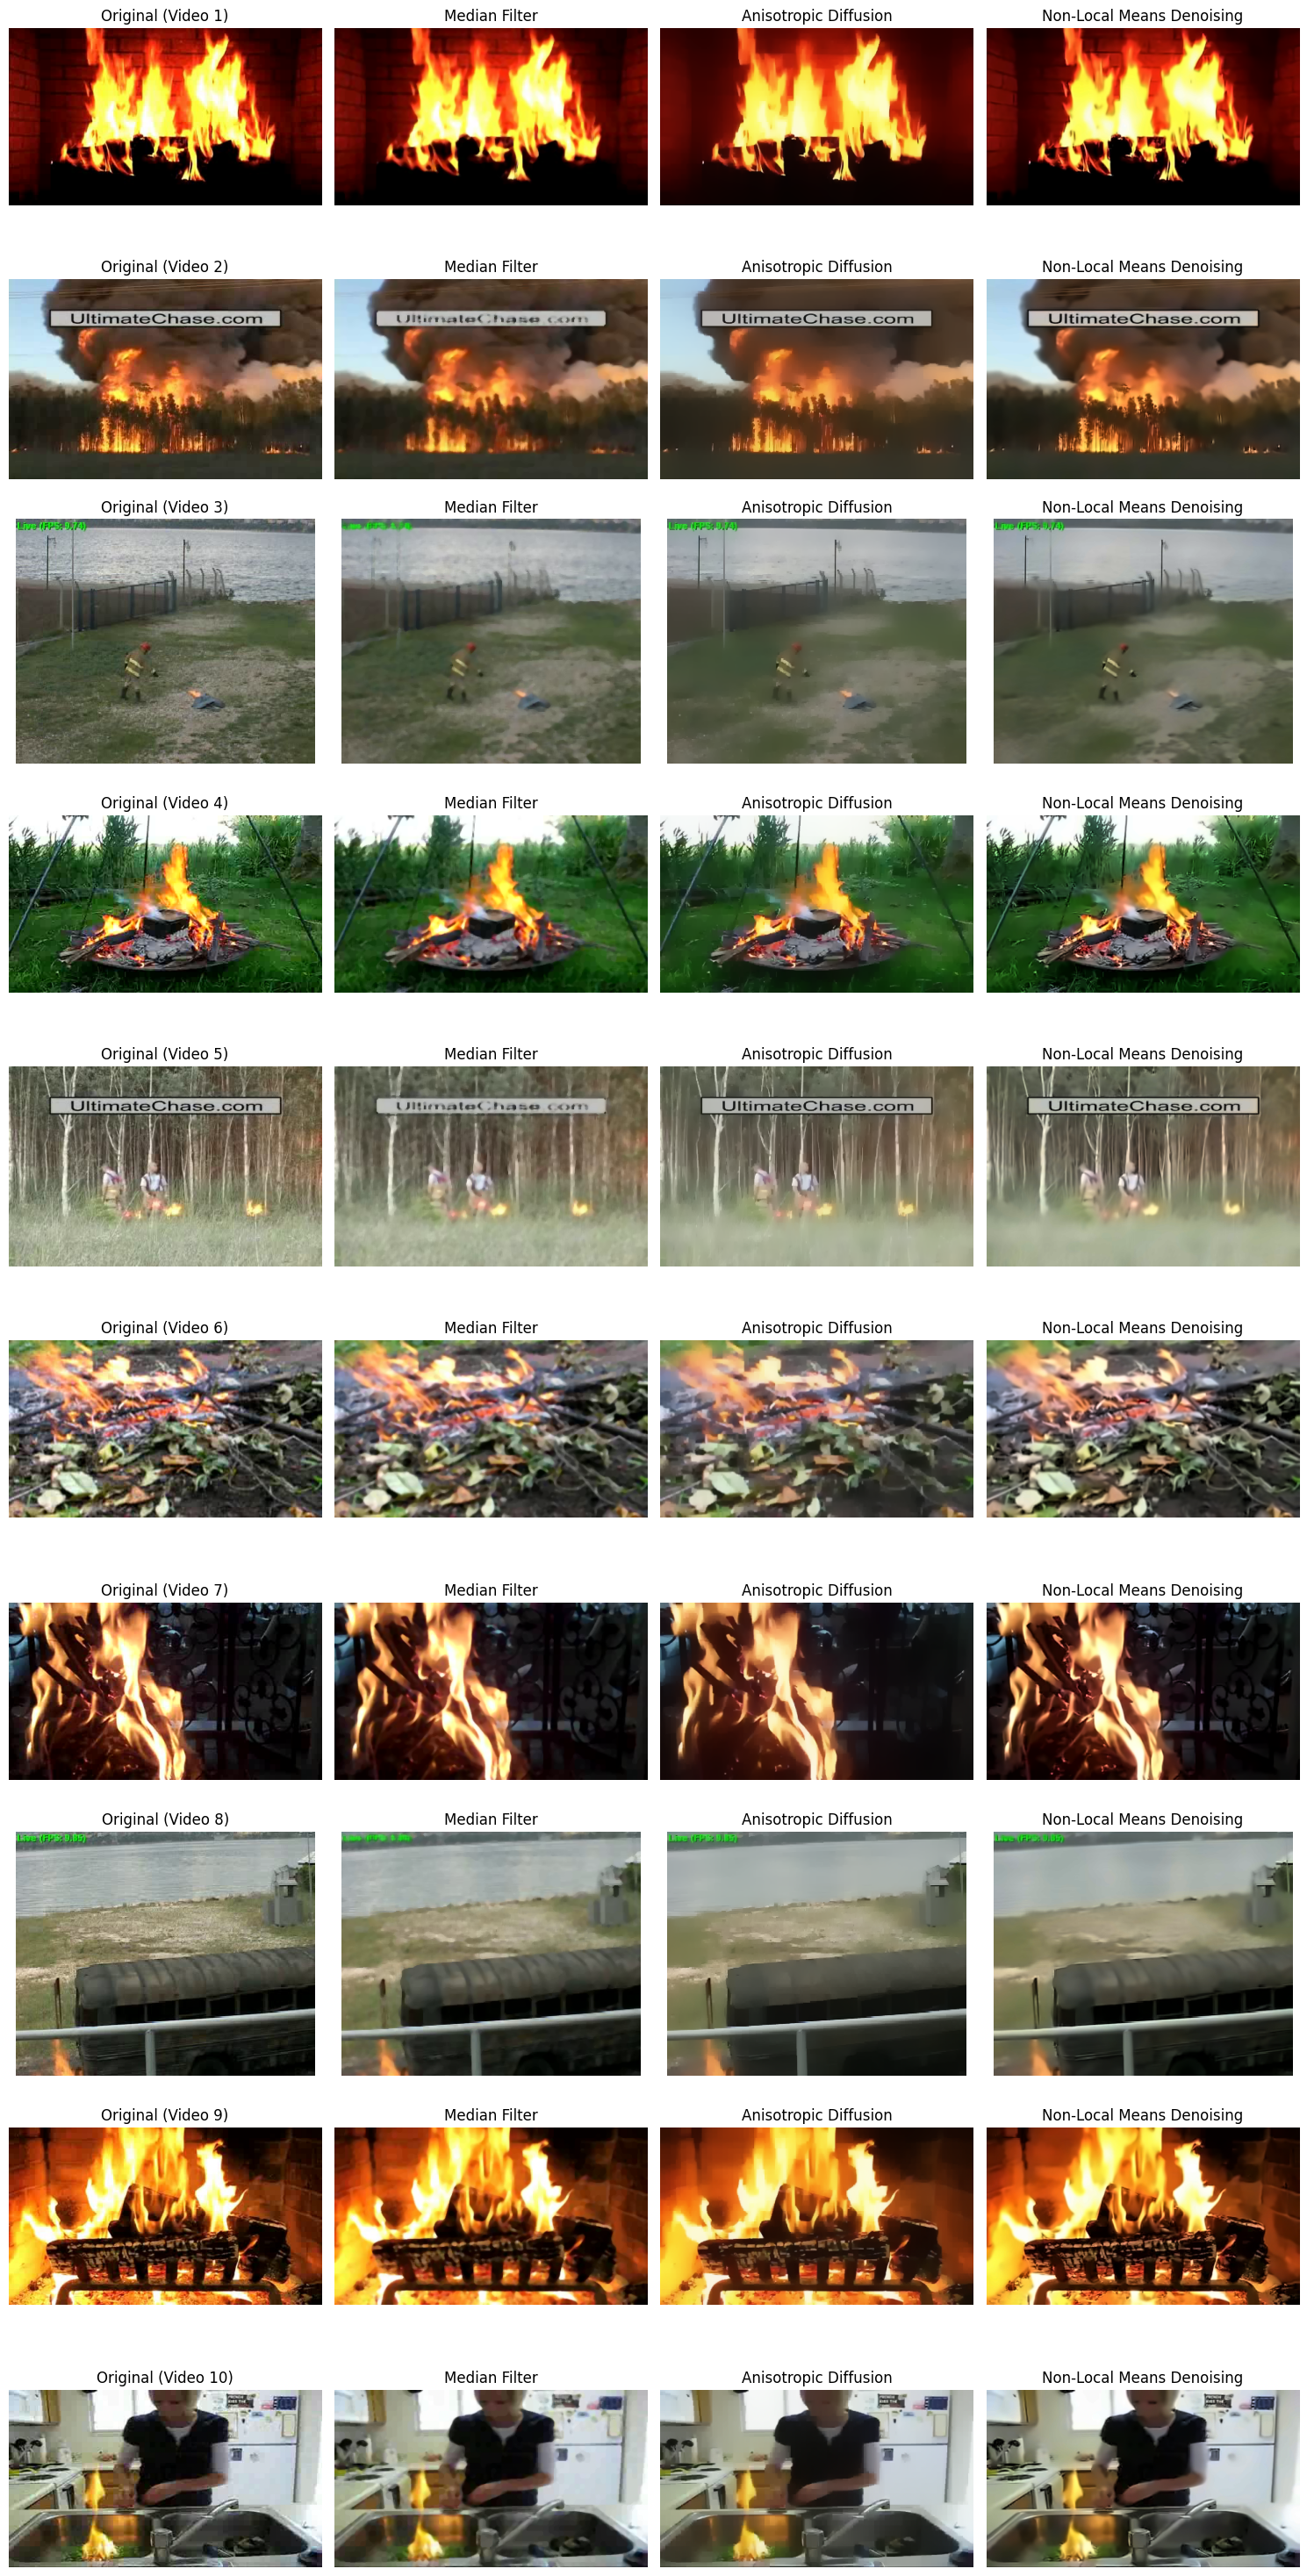

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the path to your dataset (update this based on your dataset folder name)
video_dir = "/kaggle/input/firesense/fire/pos"  # Change this to match your dataset
video_files = [f for f in os.listdir(video_dir) if f.endswith(('.mp4', '.avi', '.mov'))]

# Ensure at least 10 videos exist
video_files = video_files[:10]  # Select only the first 10 videos

if len(video_files) < 10:
    print(f"Only found {len(video_files)} videos, proceeding with available.")

frames = []

# Read the first frame from each video
for video in video_files:
    video_path = os.path.join(video_dir, video)
    cap = cv2.VideoCapture(video_path)

    ret, frame = cap.read()
    if ret:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to RGB
        frames.append(frame_rgb)

    cap.release()

# Apply filters to each frame
processed_frames = []
for frame in frames:
    # Median Filter
    median_filtered = cv2.medianBlur(frame, 5)
    
    # Anisotropic Diffusion (Using OpenCV's Edge-Preserving Filter)
    aniso_diffused = cv2.edgePreservingFilter(frame, flags=cv2.RECURS_FILTER)
    
    # Non-Local Means Denoising
    nlm_denoised = cv2.fastNlMeansDenoisingColored(frame, None, 10, 10, 7, 21)
    
    processed_frames.append((frame, median_filtered, aniso_diffused, nlm_denoised))

# Plot the results
fig, axes = plt.subplots(len(processed_frames), 4, figsize=(15, 30))

for i, (original, median, aniso, nlm) in enumerate(processed_frames):
    axes[i, 0].imshow(original)
    axes[i, 0].set_title(f"Original (Video {i+1})")
    
    axes[i, 1].imshow(median)
    axes[i, 1].set_title("Median Filter")
    
    axes[i, 2].imshow(aniso)
    axes[i, 2].set_title("Anisotropic Diffusion")
    
    axes[i, 3].imshow(nlm)
    axes[i, 3].set_title("Non-Local Means Denoising")
    
    for ax in axes[i]:
        ax.axis("off")

plt.tight_layout()
plt.show()


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the path to your dataset (update this based on your dataset folder name)
video_dir = "/kaggle/input/firesense/fire/pos"  # Change this to match your dataset
output_dir = "/kaggle/working/selected_frames"  # Output folder for reference images

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Get video files
video_files = [f for f in os.listdir(video_dir) if f.endswith(('.mp4', '.avi', '.mov'))]
video_files = video_files[:10]  # Select first 10 videos

if len(video_files) < 10:
    print(f"Only found {len(video_files)} videos, proceeding with available.")

frames = []

# Read the first frame from each video and save for reference
for i, video in enumerate(video_files):
    video_path = os.path.join(video_dir, video)
    cap = cv2.VideoCapture(video_path)

    ret, frame = cap.read()
    if ret:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to RGB
        frames.append(frame_rgb)

        # Save the frame as an image in the output folder
        image_path = os.path.join(output_dir, f"frame_{i+1}.jpg")
        cv2.imwrite(image_path, cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR))  # Convert back to BGR for OpenCV

    cap.release()

print(f" Saved {len(frames)} reference frames in {output_dir}")


 Saved 10 reference frames in /kaggle/working/selected_frames


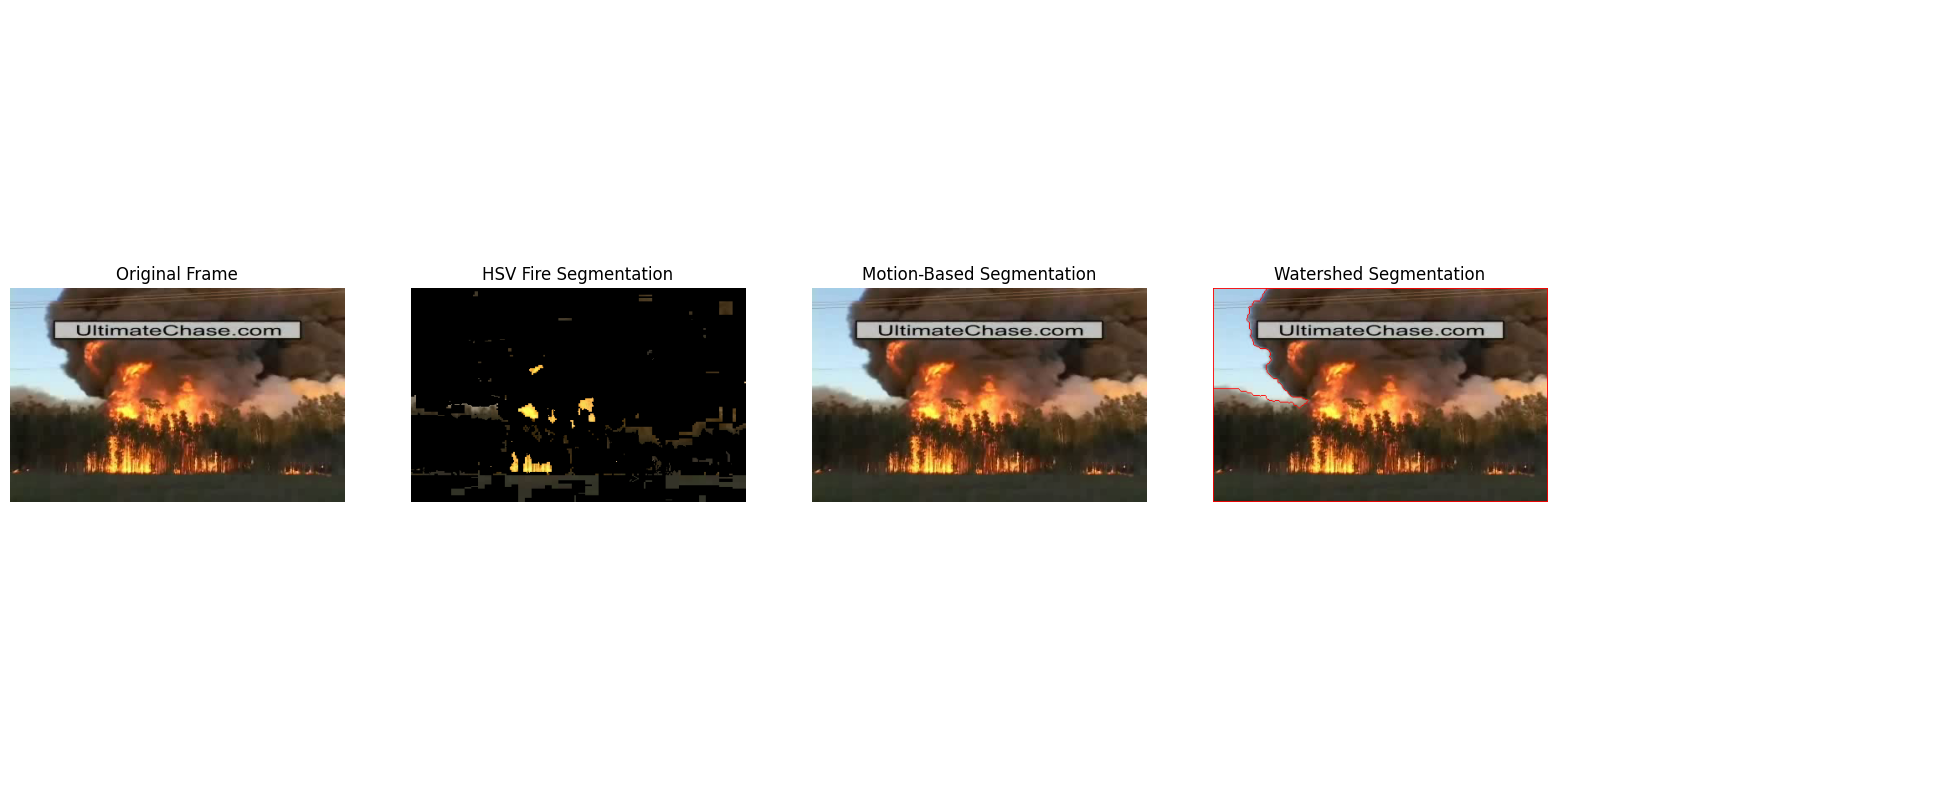

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Dataset Path
video_path = "/kaggle/input/firesense/fire/pos/posVideo10.869.avi"

# Open the video
cap = cv2.VideoCapture(video_path)

# Read the first frame
ret, frame = cap.read()
cap.release()  # Release after reading

# Convert to RGB for visualization
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# ------------------- 1️⃣ HSV Color-Based Segmentation -------------------
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

# Define fire color range in HSV
lower_fire = np.array([18, 50, 50])  # Adjust if needed
upper_fire = np.array([35, 255, 255])

# Create mask and apply it
fire_mask = cv2.inRange(hsv, lower_fire, upper_fire)
fire_segmented = cv2.bitwise_and(frame_rgb, frame_rgb, mask=fire_mask)

# ------------------- 2️⃣ Motion-Based Segmentation -------------------
# Convert to grayscale
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Simulating a previous frame (for real-time, replace with actual previous frame)
prev_frame_gray = gray_frame.copy()

# Compute frame difference
frame_diff = cv2.absdiff(prev_frame_gray, gray_frame)

# Threshold to detect moving regions
_, motion_mask = cv2.threshold(frame_diff, 25, 255, cv2.THRESH_BINARY)

# Find contours of motion
contours, _ = cv2.findContours(motion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw bounding boxes
motion_segmented = frame_rgb.copy()
for cnt in contours:
    if cv2.contourArea(cnt) > 500:  # Ignore small areas
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(motion_segmented, (x, y), (x + w, y + h), (255, 0, 0), 2)

# ------------------- 3️⃣ Watershed Segmentation -------------------
# Convert to grayscale and apply OTSU threshold
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Morphological operations to remove noise
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Distance transform for foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labeling
_, markers = cv2.connectedComponents(sure_fg)

# Add 1 to markers so unknown region becomes 0
markers = markers + 1
markers[unknown == 255] = 0

# Apply Watershed Algorithm
watershed_segmented = frame_rgb.copy()
cv2.watershed(frame, markers)
watershed_segmented[markers == -1] = [255, 0, 0]  # Mark boundaries in blue


# ------------------- Display Results -------------------
fig, axes = plt.subplots(1, 5, figsize=(25, 10))

axes[0].imshow(frame_rgb)
axes[0].set_title("Original Frame")

axes[1].imshow(fire_segmented)
axes[1].set_title("HSV Fire Segmentation")

axes[2].imshow(motion_segmented)
axes[2].set_title("Motion-Based Segmentation")

axes[3].imshow(watershed_segmented)
axes[3].set_title("Watershed Segmentation")


for ax in axes:
    ax.axis("off")

plt.show()

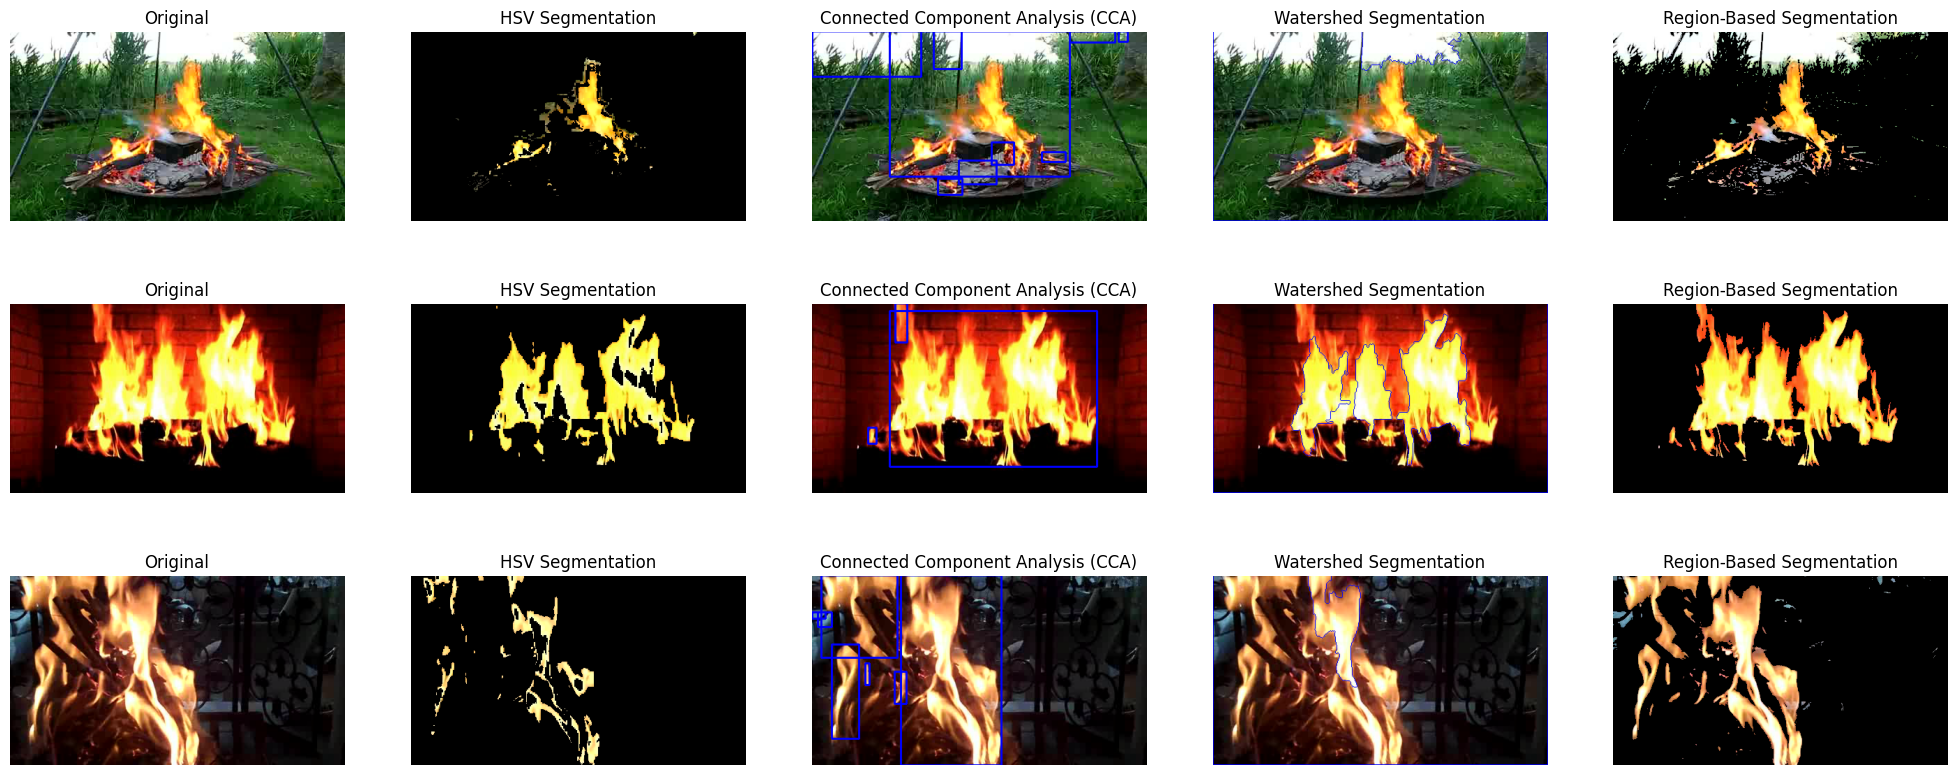

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops

# Dataset Paths
video_paths = [
    "/kaggle/input/firesense/fire/pos/posVideo9.878.avi",
    "/kaggle/input/firesense/fire/pos/posVideo4.873.avi",
    "/kaggle/input/firesense/fire/pos/posVideo8.877.avi"
]

# Function to extract first frame from video
def get_first_frame(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()
    if ret:
        return frame
    else:
        return None

# Extract frames
frames = [get_first_frame(path) for path in video_paths]

# Convert frames to RGB for visualization
frames_rgb = [cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) for frame in frames if frame is not None]

# Function for HSV Color-Based Fire Segmentation
def hsv_segmentation(frame):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower_fire = np.array([18, 50, 50])
    upper_fire = np.array([35, 255, 255])
    mask = cv2.inRange(hsv, lower_fire, upper_fire)
    return cv2.bitwise_and(frame, frame, mask=mask)

# Function for Connected Component Analysis (CCA)
def connected_component_analysis(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    labeled_img = label(binary)
    cca_output = frame.copy()
    
    for region in regionprops(labeled_img):
        if region.area >= 100:
            minr, minc, maxr, maxc = region.bbox
            cv2.rectangle(cca_output, (minc, minr), (maxc, maxr), (255, 0, 0), 2)
    
    return cca_output

# Function for Watershed Segmentation
def watershed_segmentation(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    frame_copy = frame.copy()
    cv2.watershed(frame, markers)
    frame_copy[markers == -1] = [255, 0, 0]
    return frame_copy

# Function for Region-Based Segmentation (Thresholding)
def region_segmentation(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, region_mask = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return cv2.bitwise_and(frame, frame, mask=region_mask)

# Apply all segmentation methods
segmented_results = []

for frame in frames:
    segmented_results.append({
        "original": frame,
        "HSV Segmentation": hsv_segmentation(frame),
        "CCA": connected_component_analysis(frame),
        "Watershed": watershed_segmentation(frame),
        "Region-Based": region_segmentation(frame),
    })

# Display results
fig, axes = plt.subplots(len(frames), 5, figsize=(25, 10))

for i, result in enumerate(segmented_results):
    axes[i, 0].imshow(cv2.cvtColor(result["original"], cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title("Original")

    axes[i, 1].imshow(cv2.cvtColor(result["HSV Segmentation"], cv2.COLOR_BGR2RGB))
    axes[i, 1].set_title("HSV Segmentation")

    axes[i, 2].imshow(cv2.cvtColor(result["CCA"], cv2.COLOR_BGR2RGB))
    axes[i, 2].set_title("Connected Component Analysis (CCA)")

    axes[i, 3].imshow(cv2.cvtColor(result["Watershed"], cv2.COLOR_BGR2RGB))
    axes[i, 3].set_title("Watershed Segmentation")

    axes[i, 4].imshow(cv2.cvtColor(result["Region-Based"], cv2.COLOR_BGR2RGB))
    axes[i, 4].set_title("Region-Based Segmentation")

for ax in axes.flatten():
    ax.axis("off")

plt.show()


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from sklearn.metrics import jaccard_score

# Function to compute histogram comparison
def histogram_analysis(original, segmented):
    hist_original = cv2.calcHist([original], [0], None, [256], [0, 256])
    hist_segmented = cv2.calcHist([segmented], [0], None, [256], [0, 256])
    
    # Normalize
    hist_original = hist_original / hist_original.sum()
    hist_segmented = hist_segmented / hist_segmented.sum()
    
    # Compute similarity
    similarity = cv2.compareHist(hist_original, hist_segmented, cv2.HISTCMP_CORREL)
    return similarity

# Function to compute statistical properties
def compute_stats(segmented):
    gray = cv2.cvtColor(segmented, cv2.COLOR_BGR2GRAY)
    mean_intensity = np.mean(gray)
    variance = np.var(gray)
    entropy = -np.sum((gray / 255.0) * np.log2(gray / 255.0 + 1e-8))  # Avoid log(0)
    return mean_intensity, variance, entropy

# Function for IoU approximation (using high-intensity pixels as pseudo GT)
def compute_pseudo_iou(segmented):
    gray = cv2.cvtColor(segmented, cv2.COLOR_BGR2GRAY)
    pseudo_gt = (gray > 200).astype(np.uint8)  # Consider bright areas as GT
    segmented_mask = (gray > 50).astype(np.uint8)  # Assume segmentation captured some fire
    
    # Compute IoU
    intersection = np.logical_and(pseudo_gt, segmented_mask).sum()
    union = np.logical_or(pseudo_gt, segmented_mask).sum()
    iou = intersection / (union + 1e-8)  # Avoid division by zero
    return iou

# Apply metrics to all segmented results
for i, result in enumerate(segmented_results):
    print(f"\n Metrics for Image {i+1} ")
    
    # Histogram similarity
    hist_similarity = histogram_analysis(result["original"], result["HSV Segmentation"])
    print(f"Histogram Similarity (HSV): {hist_similarity:.4f}")
    
    # Statistical properties
    mean_int, var_int, ent = compute_stats(result["HSV Segmentation"])
    print(f"Mean Intensity: {mean_int:.2f}, Variance: {var_int:.2f}, Entropy: {ent:.4f}")
    
    # IoU approximation
    iou = compute_pseudo_iou(result["HSV Segmentation"])
    print(f" IoU Approximation (Pseudo GT): {iou:.4f}")



 Metrics for Image 1 
Histogram Similarity (HSV): 0.7029
Mean Intensity: 7.78, Variance: 1461.64, Entropy: 1760.3465
 IoU Approximation (Pseudo GT): 0.4695

 Metrics for Image 2 
Histogram Similarity (HSV): 0.9952
Mean Intensity: 38.54, Variance: 7316.78, Entropy: 3250.8367
 IoU Approximation (Pseudo GT): 0.8819

 Metrics for Image 3 
Histogram Similarity (HSV): 0.7571
Mean Intensity: 12.37, Variance: 2702.56, Entropy: 938.9250
 IoU Approximation (Pseudo GT): 0.9519
